# Bzsolenoid 
---
This object wraps the simple Bzsolenoid model in GPT which models a solenoid magnet as a uniform sheet of current with length $L$, radius $R$, and current $nI$.

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Basic Usage

In [2]:
from matplotlib import pyplot as plt
import matplotlib 

import numpy as np

from gpt.bstatic import Bzsolenoid
from gpt import GPT

import os

from scipy.constants import physical_constants

MC2 = physical_constants['electron mass energy equivalent in MeV'][0]*1e6
c = physical_constants['speed of light in vacuum'][0]

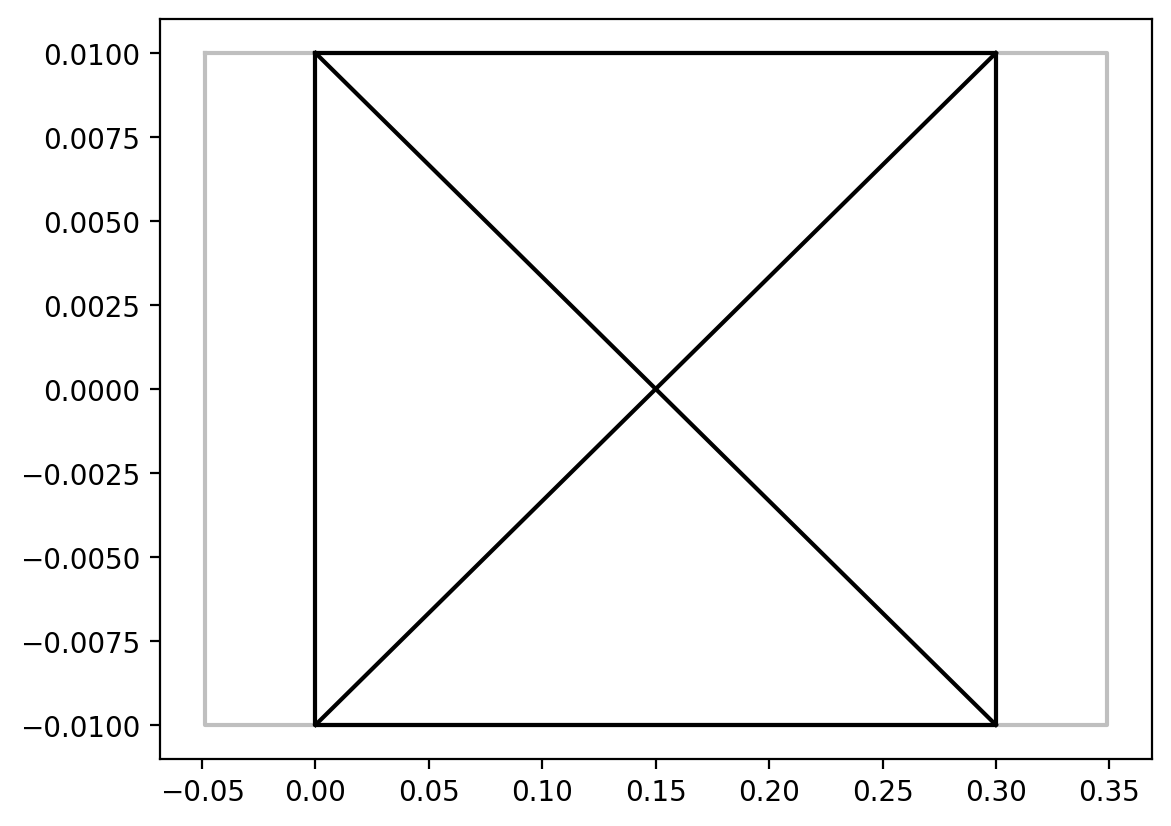

In [3]:
sol = Bzsolenoid('sol1', 0.3, 0.01, 1000)
sol.place()
sol.plot_floor()

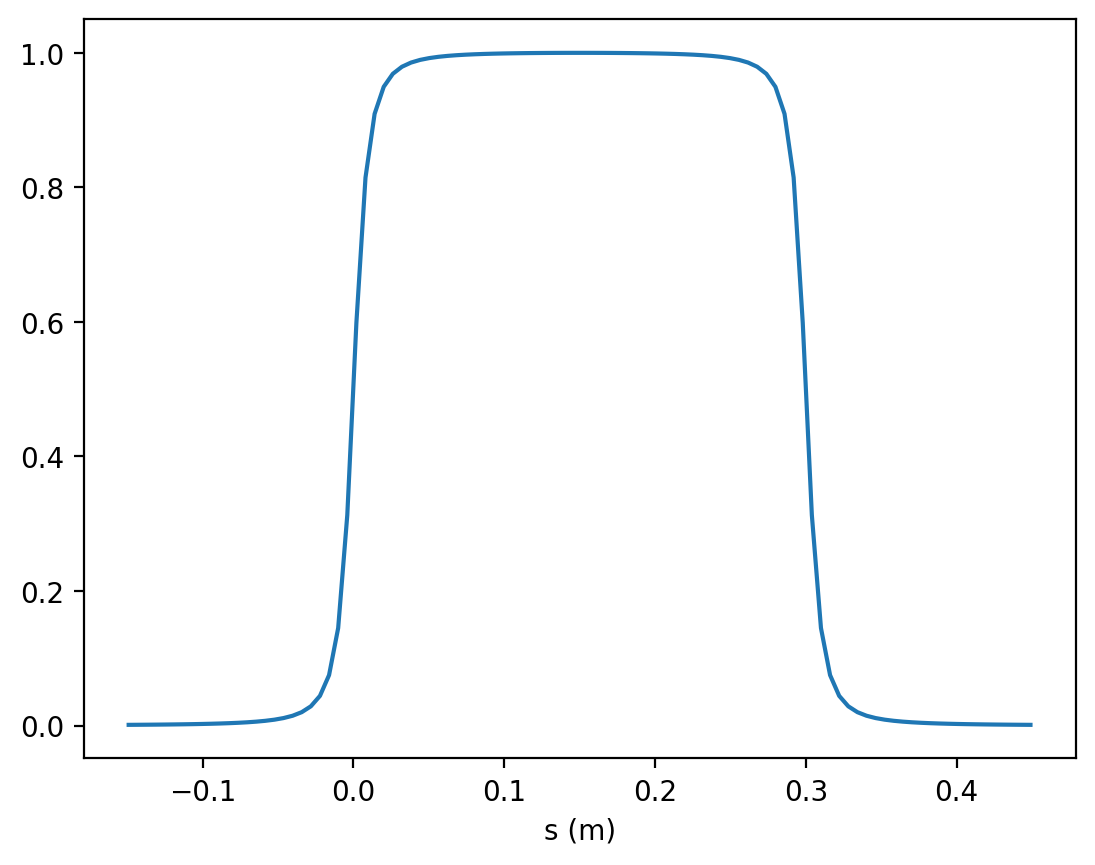

In [4]:
sol.plot_field_profile(normalize=True)

In [5]:
sol.gpt_lines()

['\n#***********************************************',
 '#               Bzsolenoid: sol1         ',
 '#***********************************************',
 'sol1_x = 0;',
 'sol1_y = 0;',
 'sol1_z = 0.15;\nsol1_yaw = 0;',
 'sol1_pitch = 0;',
 'sol1_roll = 0;\n',
 'sol1_R = 0.01;',
 'sol1_L = 0.3;',
 'sol1_bs_field = 0.00125663706212;',
 'sol1_mu0 = 1.25663706212e-06;',
 'sol1_nI = sol1_bs_field/sol1_mu0;',
 'sol1_x = 0;',
 'sol1_y = 0;',
 'sol1_z = 0.15;',
 '\nbzsolenoid("wcs", "LxyzXYZ", sol1_x, sol1_y, sol1_z, sol1_yaw, sol1_pitch, sol1_roll,  sol1_R, sol1_L, sol1_nI);']

## With Lattice Generation

In [6]:
from gpt.lattice import Lattice

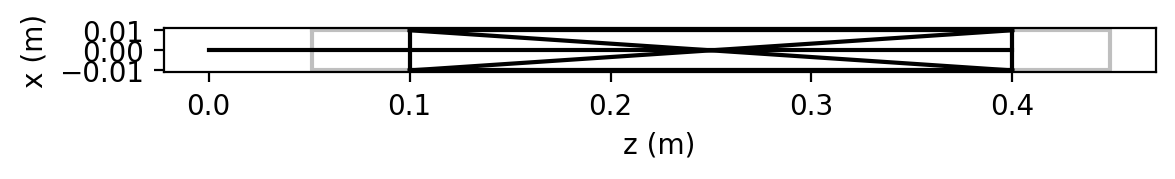

In [7]:
lat = Lattice('Bzsol')
lat.add(Bzsolenoid('sol1', 0.3, 0.01, 1000), ds=0.25, element_origin='center')
lat.plot_floor()

lat.write_gpt_lines(output_file='gpt.temp.in');

In [8]:
from distgen import Generator

E = 1e6
pz = np.sqrt(E**2 - MC2**2)

DISTGEN_YAML=f"""
n_particle: 1000
random_type: hammersley
species: electron

total_charge:
  units: nC
  value: 1
start:
  type: time
r_dist:
  sigma_xy:
    units: mm
    value: 1
  alpha:
    units: dimensionless
    value: 0.0
  type: rsg
transforms:
  avgpz:
    type: set_avg pz
    avg_pz: {pz} eV/c
"""

In [9]:
D = Generator(DISTGEN_YAML)
P = D.run()

In [10]:
G = GPT('gpt.temp.in', initial_particles=P)
G.set_variables({'ZSTOP': 1, 'Ntout': 500, 'sol1_bs_field': 0.02})
G.run()

{'name': 'sol1', 'type': 'bzsolenoid', 'x0': 0.0, 'y0': 0.0, 'z0': 0.25, 'yaw': 0.0, 'pitch': 0.0, 'roll': 0.0, 'params': {'sol1_x': 0.0, 'sol1_y': 0.0, 'sol1_z': 0.25, 'sol1_yaw': 0.0, 'sol1_pitch': 0.0, 'sol1_roll': 0.0, 'sol1_R': 0.01, 'sol1_L': 0.3, 'sol1_bs_field': 0.00125663706212, 'sol1_mu0': 1.25663706212e-06}}


<Axes: xlabel='z (m)', ylabel='x (m)'>

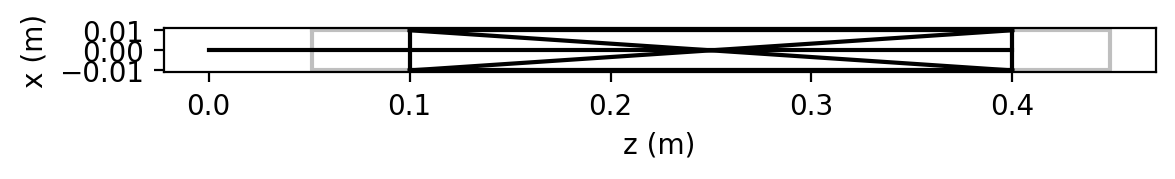

In [11]:
G.lattice.plot_floor()

Text(0, 0.5, '$\\sigma_x$ (mm)')

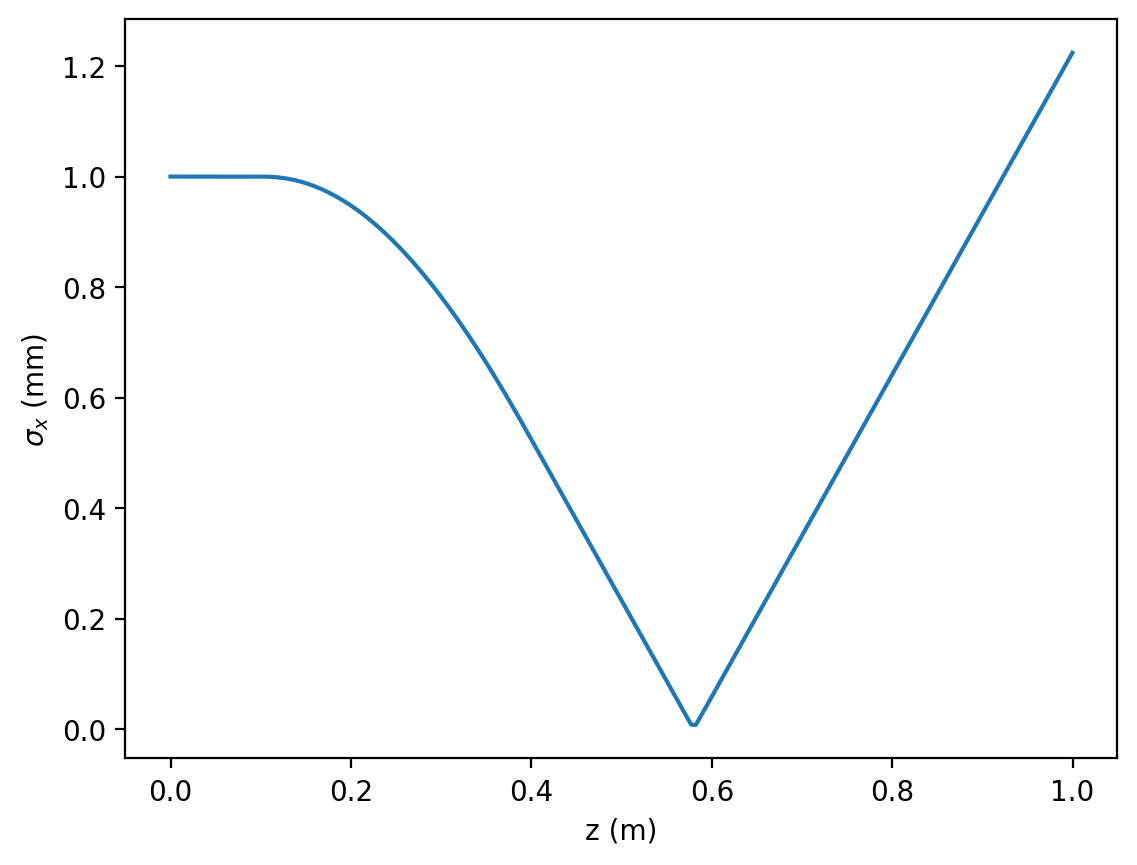

In [12]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('sigma_x')*1e3)
plt.xlabel('z (m)')
plt.ylabel(r'$\sigma_x$ (mm)')

# Checks
---

In [15]:
def check_parsing():
    
    lat1 = Lattice('Ptest')
    lat1.add(Bzsolenoid('sol1', 0.3, 0.01, 1000), ds=0.25, element_origin='center')
    lat1.write_gpt_lines(output_file='parse_test.temp.in');

    G = GPT('parse_test.temp.in')
    lat2 = G.lattice

    os.remove('parse_test.temp.in')

    # Basic info
    assert lat1['sol1']._length==lat2['sol1']._length
    assert lat1['sol1']._width==lat2['sol1']._width
    assert lat1['sol1']._height==lat2['sol1']._height
    assert lat1['sol1']._ecs==lat2['sol1']._ecs
    assert lat1['sol1'].name == lat2['sol1'].name

    # Element specific
    assert lat1['sol1'].L == lat2['sol1'].L
    assert lat1['sol1'].R == lat2['sol1'].R
    assert lat1['sol1'].bs_field == lat2['sol1'].bs_field
   
    

check_parsing()

{'name': 'sol1', 'type': 'bzsolenoid', 'x0': 0.0, 'y0': 0.0, 'z0': 0.25, 'yaw': 0.0, 'pitch': 0.0, 'roll': 0.0, 'params': {'sol1_x': 0.0, 'sol1_y': 0.0, 'sol1_z': 0.25, 'sol1_yaw': 0.0, 'sol1_pitch': 0.0, 'sol1_roll': 0.0, 'sol1_R': 0.01, 'sol1_L': 0.3, 'sol1_bs_field': 0.00125663706212, 'sol1_mu0': 1.25663706212e-06}}
